In [664]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model

import warnings
warnings.filterwarnings("ignore")

## SDE Side Data

In [665]:
sde_df = pd.read_csv('Salary_Dataset_with_Extra_Features.csv')
#sde_df.head(5)

In [666]:
sde_df.drop({'Job Title','Rating','Company Name','Salaries Reported','Location','Job Roles'},axis=1,inplace=True)

In [667]:
sde_df.head()

,Salary,Employment Status
0,400000,Full Time
1,400000,Full Time
2,1000000,Full Time
3,300000,Full Time
4,600000,Full Time


In [668]:
sde_df['salary_in_usd '] = sde_df['Salary']*0.012
sde_df.rename(columns={'Employment Status': 'employment_type'}, inplace=True)

In [669]:
sde_df.drop({'Salary',},axis=1,inplace=True)

In [670]:
sde_df['company_location'] = '1'
sde_df['employee_residence'] = '1'
sde_df['job_title '] = '4'
sde_df.employment_type.replace({"Full Time":1,"Intern":2,"Contractor":3,"Trainee":4},inplace=True)

In [671]:
def expereince_level_encoding(x):
    if x==1:
        return 1
    elif x==2:
        return 2
    elif x==3:
        return 3
    elif x==4:
        return 4
sde_df['experience_level'] = sde_df['employment_type'].apply(expereince_level_encoding)

In [672]:
sde_df.rename(columns={'salary_in_usd ':'salary_in_usd','company_location': 'company_location_fact', 'employee_residence': 'employee_residence_fact','job_title ':'job_title_fact'}, inplace=True)

In [673]:
import pandas as pd

new_sde_df = pd.DataFrame(columns=sde_df.columns)

# Specify the desired column order
column_order = ['experience_level', 'employment_type', 'salary_in_usd',
                 'company_location_fact', 'employee_residence_fact','job_title_fact']

# Reorder columns in new_sde_df
new_sde_df = new_sde_df[column_order]

# Now you can assign values to its columns
new_sde_df['experience_level'] = sde_df['experience_level']
new_sde_df['employment_type'] = sde_df['employment_type']
new_sde_df['salary_in_usd'] = sde_df['salary_in_usd']
new_sde_df['company_location_fact'] = sde_df['company_location_fact']
new_sde_df['employee_residence_fact'] = sde_df['employee_residence_fact']
new_sde_df['job_title_fact'] = sde_df['job_title_fact']


In [674]:
new_sde_df.columns

Index(['experience_level', 'employment_type', 'salary_in_usd',
       'company_location_fact', 'employee_residence_fact', 'job_title_fact'],
      dtype='object')

## Data Side Excel

In [675]:
df=pd.read_csv('ds_salaries.csv')

In [676]:
df_salary.shape

(607, 12)

In [677]:
df_salary.columns

Index(['Unnamed: 0', 'work_year', 'experience_level', 'employment_type',
       'job_title', 'salary', 'salary_currency', 'salary_in_usd',
       'employee_residence', 'remote_ratio', 'company_location',
       'company_size'],
      dtype='object')

## EDA

<Axes: xlabel='work_year', ylabel='count'>

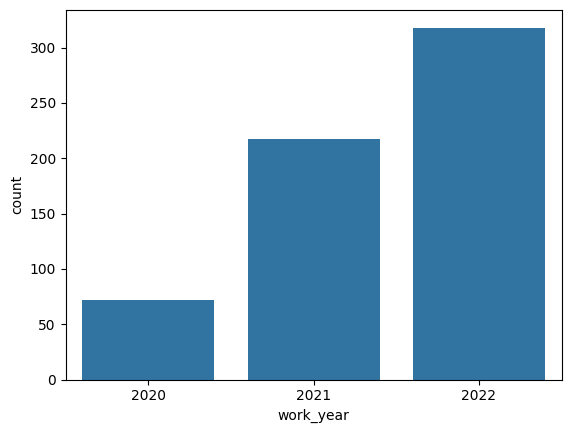

In [678]:
sns.countplot(x='work_year', data=df_salary)

The experience level in the job during the year with the following possible values: EN Entry-level / Junior MI Mid-level / Intermediate SE Senior-level / Expert EX Executive-level / Director. We can see Senior-level has highest count followed by Intermediate level and entry-level. Executive level being the least count.

<Axes: xlabel='experience_level', ylabel='count'>

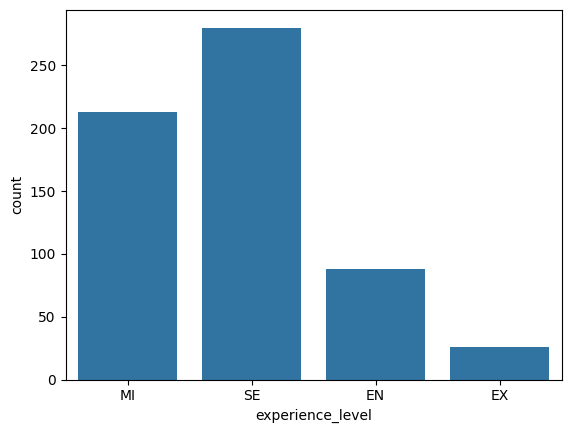

In [679]:
sns.countplot(x='experience_level', data=df_salary)

The type of employement for the role: PT Part-time FT Full-time CT Contract FL Freelance. We can see full time surpassing all other employment type by a big margin then part- time comes next. Contract and Freelance share least percentage in employment type.

<Axes: xlabel='employment_type', ylabel='count'>

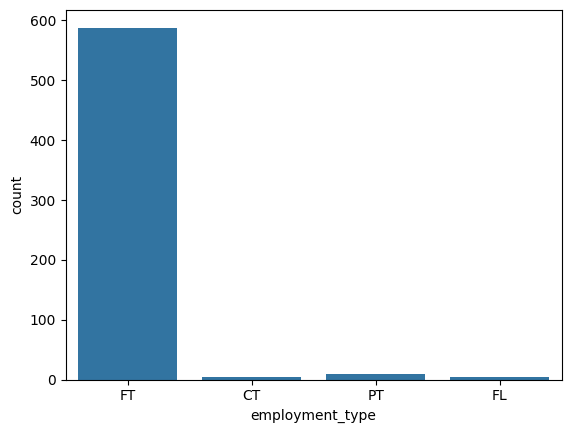

In [680]:
sns.countplot(x='employment_type', data=df_salary)

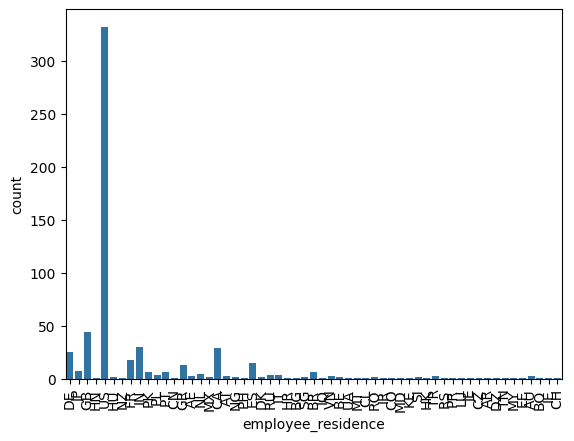

In [681]:
sns.countplot(x='employee_residence', data=df_salary)
plt.xticks(rotation=90)
plt.show()

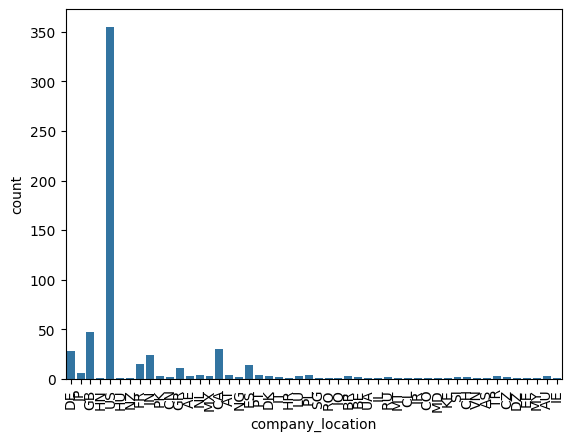

In [682]:
sns.countplot(x='company_location', data=df_salary)
plt.xticks(rotation=90)
plt.show()

<Axes: xlabel='company_size', ylabel='count'>

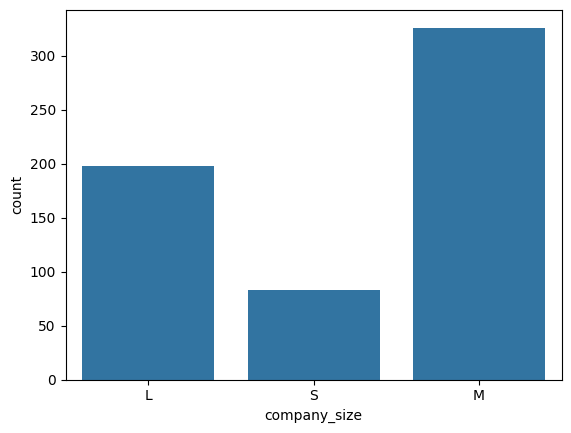

In [683]:
sns.countplot(x='company_size', data=df_salary)

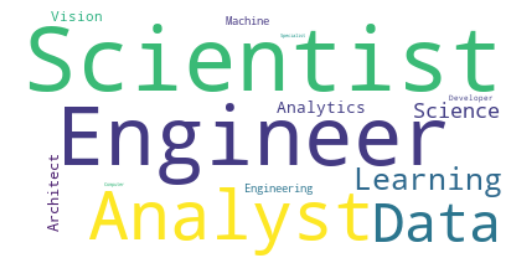

In [684]:
text = " ".join(cat.split()[1] for cat in df_salary.job_title)
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Data Prepration

In [685]:
# X = df_salary.drop(['Unnamed: 0','salary', 'salary_currency','salary_in_usd','remote_ratio'], axis=1)
# y = df_salary['salary_in_usd']

In [686]:
#X = pd.get_dummies(X)

In [687]:
# Function to detect outliers in every feature
def detect_outliers(df):
    cols = list(df)
    outliers = pd.DataFrame(columns = ['Feature', 'Number of Outliers'])
    for column in cols:
        if column in df.select_dtypes(include=np.number).columns:
            q1 = df[column].quantile(0.25)
            q3 = df[column].quantile(0.75)
            iqr = q3 - q1
            fence_low = q1 - (1.5*iqr)
            fence_high = q3 + (1.5*iqr)
            outliers = outliers.append({'Feature':column, 'Number of Outliers':df.loc[(df[column] < fence_low) | (df[column] > fence_high)].shape[0]},ignore_index=True)
    return outliers


In [688]:
#detect_outliers(df)

In [689]:
# Function to detect outliers in every feature and fix it
def solve_outliers(df):
    outliers= pd.DataFrame(columns=["Feature","NO Outliers","Handled?"])
    for col in list(set(df.select_dtypes(include=np.number).columns)-{'Outcome'}):
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        fence_low = q1 - (1.5*iqr)
        fence_high = q3 + (1.5*iqr)
        N_O_O = df.loc[(df[col] < fence_low) | (df[col] > fence_high)].shape[0]
                   
        df.loc[(df[col] < fence_low),col] = fence_low
        df.loc[(df[col] > fence_high),col] = fence_high
        #let's fix them
        #df[col] = np.where((df[col] > fence_high) | (df[col] > fence_high),df[col].median(),df[col])
        outliers = outliers.append({'Feature': col, "NO Outliers": N_O_O ,"Handled?": df[col].all() < fence_high},ignore_index=True)
    return outliers


In [690]:
#solve_outliers(df)

In [691]:
#detect_outliers(df)

In [692]:
df.experience_level.replace({"EN":1,"MI":2,"SE":3,"EX":4},inplace=True)

In [693]:
df.employment_type.replace({"FT":1,"PT":2,"CT":3,"FL":4},inplace=True)

In [694]:
df.company_size.replace({"M":1,"S":2,"L":3},inplace=True)

In [695]:
def not_usa(x):
    if x!='US':
        return 0
    return 1
df['company_location_fact'] = df['company_location'].apply(not_usa)

In [696]:
def not_usa(x):
    if x!='US':
        return 0
    return 1
df['employee_residence_fact'] = df['employee_residence'].apply(not_usa)

In [697]:
def designation_encoding(x):
    if x=='Data Scientist':
        return 0
    elif x=="Data Engineer":
        return 1
    elif x=="Data Analyst":
        return 2
    elif x=="Machine Learning Engineer":
        return 3
    return 4
df['job_title_fact'] = df['job_title'].apply(designation_encoding)

In [698]:
df.drop({'Unnamed: 0','work_year','company_size','salary','salary_currency','remote_ratio',"employee_residence","company_location",'company_size',"job_title"},axis=1,inplace=True)

In [699]:
df.columns

Index(['experience_level', 'employment_type', 'salary_in_usd',
       'company_location_fact', 'employee_residence_fact', 'job_title_fact'],
      dtype='object')

In [700]:
new_sde_df.columns

Index(['experience_level', 'employment_type', 'salary_in_usd',
       'company_location_fact', 'employee_residence_fact', 'job_title_fact'],
      dtype='object')

# Conacatenating 2 datasets

In [701]:
print(df.isnull().sum())


experience_level           0
employment_type            0
salary_in_usd              0
company_location_fact      0
employee_residence_fact    0
job_title_fact             0
dtype: int64


In [702]:
print(new_sde_df.isnull().sum())

experience_level           0
employment_type            0
salary_in_usd              0
company_location_fact      0
employee_residence_fact    0
job_title_fact             0
dtype: int64


In [703]:
new_df = pd.concat([df, new_sde_df], ignore_index=True)

In [704]:
new_df.to_csv('new_df.csv')

In [705]:
print(new_df.isnull().sum())

experience_level           0
employment_type            0
salary_in_usd              0
company_location_fact      0
employee_residence_fact    0
job_title_fact             0
dtype: int64


In [706]:
new_df.shape

(23377, 6)

In [707]:
#new_df=df
# new_df=new_sde_df
# new_df.shape

In [708]:
x = new_df.drop('salary_in_usd',axis=1)

In [709]:
x

,experience_level,employment_type,company_location_fact,employee_residence_fact,job_title_fact
0,2,1,0,0,0
1,3,1,0,0,4
2,3,1,0,0,4
3,2,1,0,0,4
4,3,1,1,1,3
...,...,...,...,...,...
23372,1,1,1,1,4
23373,1,1,1,1,4
23374,1,1,1,1,4
23375,1,1,1,1,4


In [710]:
y = new_df['salary_in_usd']

In [711]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, 
                                                    y, test_size=0.30, 
                                                    random_state=101)

In [712]:
# X_train = X_train.values.reshape(-1, 1)
# y_train = y_train.values.reshape(-1, 1)

In [713]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [714]:
X_train.shape

(16363, 5)

In [715]:
y_train.shape

(16363,)

In [716]:
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression()

In [717]:
lm.score(X_train, y_train)

0.514460315382371

In [718]:
y_test.shape

(7014,)

In [719]:
y_pred_test.shape

(6831,)

In [720]:
y_pred_test = lm.predict(X_test)
y_pred_test

array([8992.60676633, 8992.60676633, 8992.60676633, ..., 8992.60676633,
       8992.60676633, 8992.60676633])

In [721]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred_test)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 148562263.65589416


In [722]:
rmse = np.sqrt(mse)
rmse

12188.612047968963

In [723]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred_test)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 6340.18032094983


In [724]:
import pickle
pickle.dump(lm,open('new_linear_regression_model.pickle','wb'))